<a href="https://colab.research.google.com/github/Ayushpal11/Data_Science/blob/main/Ayush_Pal_Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zeotap Data Science Internship Task - 2

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
customers_path = '/content/drive/MyDrive/ZeoTap/Customers.csv'
products_path = '/content/drive/MyDrive/ZeoTap/Products.csv'
transactions_path = '/content/drive/MyDrive/ZeoTap/Transactions.csv'
customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)
transactions_df = pd.read_csv(transactions_path)
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
region_encoder = LabelEncoder()
category_encoder = LabelEncoder()
customers_df['Region_encoded'] = region_encoder.fit_transform(customers_df['Region'])
products_df['Category_encoded'] = category_encoder.fit_transform(products_df['Category'])

# Step 3: Feature Engineering
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')
customer_transactions = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()
customers_df = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')

# Step 4: Create customer vectors (profile + transaction history)
customer_features = ['Region_encoded', 'total_spent', 'num_transactions', 'avg_transaction_value']
scaler = StandardScaler()
customers_df[['total_spent', 'num_transactions', 'avg_transaction_value']] = scaler.fit_transform(
    customers_df[['total_spent', 'num_transactions', 'avg_transaction_value']]
)

# Step 5: Compute similarity between customers
customers_df.dropna(subset=customer_features, inplace=True)
customer_vectors = customers_df[customer_features].values
similarity_matrix = cosine_similarity(customer_vectors)

# Step 6: Generate lookalike recommendations for the first 20 customers
top_lookalikes = {}
for i in range(100):
    similarity_scores = similarity_matrix[i]
    similar_customers = [(customers_df['CustomerID'].iloc[j], similarity_scores[j]) for j in range(len(customer_vectors)) if i != j]
    similar_customers_sorted = sorted(similar_customers, key=lambda x: x[1], reverse=True)[:5]
    top_lookalikes[customers_df['CustomerID'].iloc[i]] = similar_customers_sorted # Use iloc to access by position

# Step 7: Prepare the output (Lookalike.csv)
lookalike_data = []
for cust_id, similar_customers in top_lookalikes.items():
    for similar_cust, score in similar_customers:
        lookalike_data.append([cust_id, similar_cust, score])
lookalike_df = pd.DataFrame(lookalike_data, columns=['CustomerID', 'LookalikeCustomerID', 'SimilarityScore'])
lookalike_output_path = '/content/drive/MyDrive/ZeoTap/Lookalike.csv'
lookalike_df.to_csv(lookalike_output_path, index=False)
lookalike_df.head()

,CustomerID,LookalikeCustomerID,SimilarityScore
0,C0001,C0137,0.999973
1,C0001,C0152,0.999945
2,C0001,C0107,0.995940
3,C0001,C0191,0.993011
4,C0001,C0190,0.992422


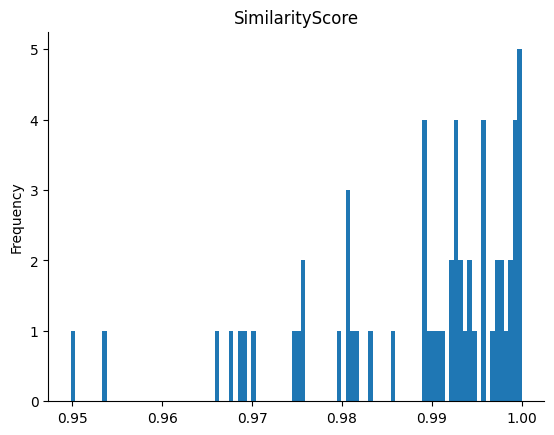

In [24]:
from matplotlib import pyplot as plt
lookalike_df['SimilarityScore'].plot(kind='hist', bins=100, title='SimilarityScore')
plt.gca().spines[['top', 'right',]].set_visible(False)